# Exploración de los datos

In [1]:
# Condicional para pip installs
if 'ALREADY_EXECUTED' not in globals():
    # Necesario para parquet
    !pip -q install pyarrow

    # Librerias varias
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    import torch
    import torch.nn as nn
    import torch.nn.functional as F

    # Cosillas google drive
    from google.colab import drive
    drive.mount('/content/drive')
    print("This code runs only once.")
    ALREADY_EXECUTED = True
else:
    print("This cell has already been executed in this session.")

Mounted at /content/drive
This code runs only once.


In [2]:
# Se incorporan los 3 dataframes
# Paths
detect_path = '/content/drive/My Drive/Proyecto SN Classifier EL4106/detections_SNe_v7.0.1.csv'
crossmatch_path = '/content/drive/My Drive/Proyecto SN Classifier EL4106/dfcrossmatches_prioritized_v7.0.1.csv'
lc_features_path = '/content/drive/My Drive/Proyecto SN Classifier EL4106/features_cleaned.parquet'

# Dataframes
detect = pd.read_csv(detect_path) # Detecciones ZTF (sirve para gráficos de LC)
crossm = pd.read_csv(crossmatch_path) # Crossmatch con otros catalogos (tiene las labels)
lc_feat = pd.read_parquet(lc_features_path) # Caracteristicas de LC (features para clasificación)


In [3]:
crossm

,oid,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
0,ZTF19abegncu,AGN,357.296363,-8.941186,NaN,Oh2015,5.8772718059579e+17,AGN_galaxy_dominated,0.243081
1,ZTF18acejdhu,AGN,11.958444,-10.496615,NaN,Oh2015,5.877272256953059e+17,AGN_galaxy_dominated,0.301126
2,ZTF18acdzene,AGN,17.478620,-10.110250,NaN,Oh2015,5.877271789938934e+17,AGN_galaxy_dominated,0.158643
3,ZTF18abwzuzw,AGN,25.038255,-10.352430,NaN,Oh2015,5.877272294485526e+17,AGN_galaxy_dominated,0.485322
4,ZTF19abmposz,AGN,26.670031,-8.354787,NaN,Oh2015,5.877271806085038e+17,AGN_galaxy_dominated,0.213990
...,...,...,...,...,...,...,...,...,...
173874,ZTF18abikbvc,LPV,286.720222,24.733440,NaN,GAIADR2VS,4.533629080944307e+18,MIRA_SR,0.299487
173875,ZTF19aamtoyb,LPV,99.257590,-15.567786,NaN,GAIADR2VS,2.9501070744892713e+18,MIRA_SR,0.299597
173876,ZTF19abeesgk,LPV,277.499222,-27.002742,NaN,GAIADR2VS,4.0518162825206625e+18,MIRA_SR,0.299766
173877,ZTF18abnubuy,LPV,292.053754,38.418277,NaN,GAIADR2VS,2.0526959231045647e+18,MIRA_SR,0.299777


In [4]:
lc_feat

,oid,gal_b,gal_l,g-r_max_g_r,g-r_mean_g_r,g-r_max_corr_g_r,g-r_mean_corr_g_r,rb,MHPS_ratio_g,MHPS_low_g,...,GP_DRW_tau_g,GP_DRW_sigma_r,GP_DRW_tau_r,sgscore1,W1-W2,W2-W3,g-W2,g-W3,r-W2,r-W3
0,ZTF18aahvndq,84.778146,32.955580,-0.041541,0.246432,NaN,NaN,0.882857,254.265274,26.968182,...,66.362931,0.759076,27.720122,0.175976,NaN,NaN,NaN,NaN,NaN,NaN
1,ZTF19abqviuy,-56.280179,109.009059,-0.079274,0.021343,NaN,NaN,0.930000,75.107750,5.551193,...,53.981530,0.542258,92.358918,0.500000,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF19acyogrm,-24.613587,148.867482,1.280889,0.400809,1.227327,0.502450,0.850000,0.314363,0.056313,...,0.069667,0.385131,49.756570,0.332214,NaN,NaN,NaN,NaN,NaN,NaN
3,ZTF20aaiovoy,42.559095,209.082699,0.178904,0.587743,NaN,NaN,0.887143,13.142984,1.021393,...,18.657369,0.026580,25.050218,0.292830,NaN,NaN,NaN,NaN,NaN,NaN
4,ZTF20abcqpdj,72.178184,147.837430,0.308870,0.400827,0.498012,0.541368,0.942857,1.128955,0.027010,...,6.547652,0.009291,23.891174,0.000000,0.267,4.391,3.883968,8.274968,3.342600,7.733600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818,ZTF20aayknlo,72.683998,233.184869,-0.328528,0.383010,NaN,NaN,0.904286,93.172852,22.056648,...,33.356253,0.674075,23.753157,0.085446,NaN,NaN,NaN,NaN,NaN,NaN
1819,ZTF19abiietd,42.921826,38.536144,0.232587,0.466327,0.262361,0.409922,0.864286,59.030556,4.768975,...,81.268633,0.353625,137.488604,0.158607,0.148,3.874,3.457589,7.331589,3.047667,6.921667
1820,ZTF19abpnsck,-49.926751,212.519699,-0.219573,-0.150903,NaN,NaN,0.903571,77.930595,8.160241,...,47.061616,0.782868,129.075507,0.203339,NaN,NaN,NaN,NaN,NaN,NaN
1821,ZTF18ablqqqp,35.878791,43.288954,-0.100551,-0.033632,NaN,NaN,0.643333,NaN,3.529896,...,15.222503,0.218542,9.415108,0.008667,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Limpieza y arreglo de datos

# Verificación de que los objetos sean únicos
print(f'Objetos únicos: {lc_feat['oid'].is_unique}')

# Se verifica que todas las columnas son float64
print(f'DataFrame float64: {lc_feat.drop(columns='oid').dtypes.nunique() <= 1}')

# Valores NaN a -999 como en el paper
lc_feat = lc_feat.fillna(-999)

# Union left con labels
lc_feat = pd.merge(lc_feat, crossm[['oid','classALeRCE']], on='oid', how='left')

# Transformar a clases numéricas
species_map = {'SNIa': 0, 'SNIbc': 1, 'SNII': 2, 'SLSN': 3, 'SNIIb': 2, 'SNIIn': 2}
lc_feat['classALeRCE'] = lc_feat['classALeRCE'].map(species_map)
lc_feat

# Codificación one hot
#lc_mlp = lc_feat.drop(columns = 'oid')
#lc_mlp = pd.get_dummies(lc_feat, columns=['classALeRCE'], dtype = float)
#lc_mlp

Objetos únicos: True
DataFrame float64: True


,oid,gal_b,gal_l,g-r_max_g_r,g-r_mean_g_r,g-r_max_corr_g_r,g-r_mean_corr_g_r,rb,MHPS_ratio_g,MHPS_low_g,...,GP_DRW_sigma_r,GP_DRW_tau_r,sgscore1,W1-W2,W2-W3,g-W2,g-W3,r-W2,r-W3,classALeRCE
0,ZTF18aahvndq,84.778146,32.955580,-0.041541,0.246432,-999.000000,-999.000000,0.882857,254.265274,26.968182,...,0.759076,27.720122,0.175976,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,0
1,ZTF19abqviuy,-56.280179,109.009059,-0.079274,0.021343,-999.000000,-999.000000,0.930000,75.107750,5.551193,...,0.542258,92.358918,0.500000,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,0
2,ZTF19acyogrm,-24.613587,148.867482,1.280889,0.400809,1.227327,0.502450,0.850000,0.314363,0.056313,...,0.385131,49.756570,0.332214,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,1
3,ZTF20aaiovoy,42.559095,209.082699,0.178904,0.587743,-999.000000,-999.000000,0.887143,13.142984,1.021393,...,0.026580,25.050218,0.292830,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,2
4,ZTF20abcqpdj,72.178184,147.837430,0.308870,0.400827,0.498012,0.541368,0.942857,1.128955,0.027010,...,0.009291,23.891174,0.000000,0.267,4.391,3.883968,8.274968,3.342600,7.733600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818,ZTF20aayknlo,72.683998,233.184869,-0.328528,0.383010,-999.000000,-999.000000,0.904286,93.172852,22.056648,...,0.674075,23.753157,0.085446,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,0
1819,ZTF19abiietd,42.921826,38.536144,0.232587,0.466327,0.262361,0.409922,0.864286,59.030556,4.768975,...,0.353625,137.488604,0.158607,0.148,3.874,3.457589,7.331589,3.047667,6.921667,2
1820,ZTF19abpnsck,-49.926751,212.519699,-0.219573,-0.150903,-999.000000,-999.000000,0.903571,77.930595,8.160241,...,0.782868,129.075507,0.203339,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,0
1821,ZTF18ablqqqp,35.878791,43.288954,-0.100551,-0.033632,-999.000000,-999.000000,0.643333,-999.000000,3.529896,...,0.218542,9.415108,0.008667,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,0


# MLP con desbalance

In [6]:
# A partir de acá MLP sacada casi todo de Aux 2
# Split the data
X = lc_feat.iloc[:, 1:-1].values
y = lc_feat['classALeRCE'].values
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
y_np = lc_feat['classALeRCE'].to_numpy()
print(f'Numero de clases: {max(y_np) + 1}')

# Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy= {0: 1100}, random_state=42)
X, y = undersample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversampling usando SMOTE
from imblearn.over_sampling import SMOTE
# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy= {1: 422, 2: 633, 3: 422}, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
#print(train_y)

# Random Oversampling
#from imblearn.over_sampling import RandomOverSampler
#oversample = RandomOverSampler(sampling_strategy= {1: 400, 2:400, 3:400}, random_state=42)
#X, y = oversample.fit_resample(X, y)
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

Numero de clases: 4


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #(≈ 3 lines of code)
        # YOUR CODE STARTS HERE
        self.fc1 = nn.Linear(178, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 30)
        self.fc4 = nn.Linear(30, 15)
        self.fc5 = nn.Linear(15,4)

        # YOUR CODE ENDS HERE

    def forward(self, x):
        #(≈ 3 lines of code)
        # YOUR CODE STARTS HERE
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = self.fc5(x)

        # YOUR CODE ENDS HERE
        return x

In [8]:
# Convert to PyTorch tensors
train_X = torch.FloatTensor(X_train)
test_X = torch.FloatTensor(X_test)
train_y = torch.LongTensor(y_train)
test_y = torch.LongTensor(y_test)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determinar si se usará GPU o CPU
net = Net().to(device)  # Crear una instancia de la red y enviarla al dispositivo seleccionado
# Calculate class weights (inverse of class frequencies)
#from collections import Counter
#counts_tr = Counter(train_y.numpy())
#classes_sorted = sorted(counts_tr)
#freq = np.array([counts_tr[c] for c in classes_sorted], dtype=np.float32)
#alpha = 0.5
#wA = (freq.mean() / (freq ** alpha))
#wA = wA / wA.mean()
# Opcional: limitar extremos
#wA = np.clip(wA, 0.5, 1)  # evita que una clase pese 10x
wA = np.array([1.1,1.3,1.2,1.3])
class_weights_A = torch.tensor(wA, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights_A, label_smoothing=0.02)  # Definir la función de pérdida (entropía cruzada para problemas de clasificación)
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)  # Usar Adam como optimizador con una tasa de aprendizaje de 0.01

# Bucle de entrenamiento
num_epochs = 1000  # Definir el número de épocas de entrenamiento
for epoch in range(num_epochs):  # Iterar sobre el número de épocas
    net.train()  # Poner la red en modo de entrenamiento
    optimizer.zero_grad()  # Reiniciar los gradientes del optimizador antes de cada paso de optimización
    outputs = net(train_X.to(device))  # Hacer una pasada hacia adelante (forward pass) del modelo con los datos de entrenamiento
    loss = criterion(outputs, train_y.to(device))  # Calcular la pérdida comparando las predicciones con los valores verdaderos
    loss.backward()  # Realizar la pasada hacia atrás (backward pass) para calcular los gradientes dw
    optimizer.step()  # Actualizar los parámetros de la red usando el optimizador

    # Imprimir el progreso cada 100 épocas
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')  # Mostrar la época actual y el valor de la pérdida

# Evaluación del modelo
net.eval()  # Poner la red en modo de evaluación (desactiva dropout, batchnorm, etc.)
with torch.no_grad():  # No calcular los gradientes para la evaluación (reduce el uso de memoria y tiempo de cálculo)
    predict_out = net(test_X.to(device))  # Hacer una pasada hacia adelante con los datos de prueba
    _, predict_y = torch.max(predict_out, 1)  # Obtener las clases predichas usando la salida con mayor probabilidad

# Convertir las predicciones y las etiquetas de prueba a arrays numpy para un análisis posterior
predict_y = predict_y.cpu().numpy()
test_y = test_y.numpy()

print(f'Prediction accuracy: {accuracy_score(test_y, predict_y):.4f}')
print(f'Precision: {precision_score(test_y, predict_y, average="weighted"):.4f}')
print(f'Recall: {recall_score(test_y, predict_y, average="weighted"):.4f}')

Epoch [100/1000], Loss: 1.3008
Epoch [200/1000], Loss: 1.2070
Epoch [300/1000], Loss: 1.1482
Epoch [400/1000], Loss: 1.1099
Epoch [500/1000], Loss: 1.0770
Epoch [600/1000], Loss: 1.0649
Epoch [700/1000], Loss: 1.0571
Epoch [800/1000], Loss: 1.0543
Epoch [900/1000], Loss: 1.0552
Epoch [1000/1000], Loss: 1.0490
Prediction accuracy: 0.6731
Precision: 0.6287
Recall: 0.6731


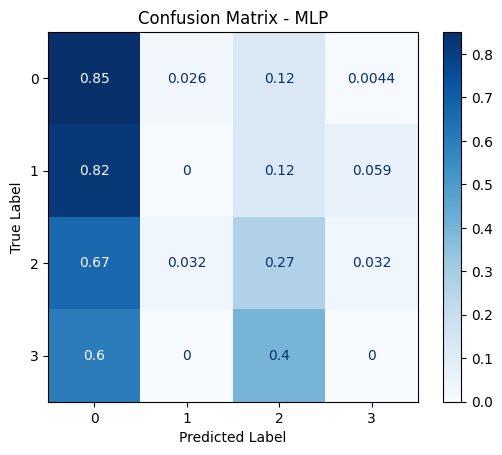

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming test_y and predict_y are your true and predicted labels
cm = confusion_matrix(test_y, predict_y, normalize='true')

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix - MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


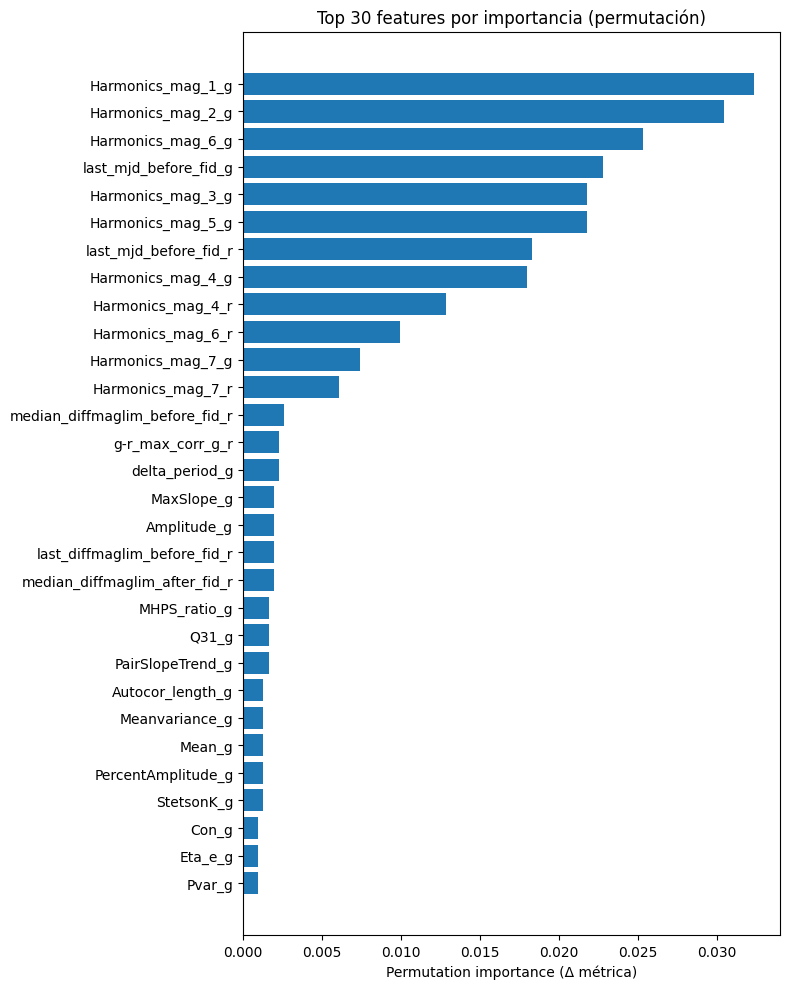

                           feature  importance  abs_importance
0                Harmonics_mag_1_g    0.032372        0.032372
1                Harmonics_mag_2_g    0.030449        0.030449
2                Harmonics_mag_6_g    0.025321        0.025321
3            last_mjd_before_fid_g    0.022756        0.022756
4                Harmonics_mag_5_g    0.021795        0.021795
5                Harmonics_mag_3_g    0.021795        0.021795
6            last_mjd_before_fid_r    0.018269        0.018269
7                Harmonics_mag_4_g    0.017949        0.017949
8                Harmonics_mag_4_r    0.012821        0.012821
9                Harmonics_mag_6_r    0.009936        0.009936
10               Harmonics_mag_7_g    0.007372        0.007372
11               Harmonics_mag_7_r    0.006090        0.006090
12  median_diffmaglim_before_fid_r    0.002564        0.002564
13                  delta_period_g    0.002244        0.002244
14                g-r_max_corr_g_r    0.002244        0

In [10]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

def calculate_permutation_importance(
    model, X_test, y_test, metric_fn=accuracy_score,
    feature_names=None, n_repeats=10, seed=42, device=None
):

    model.eval()
    if device is None:
        device = next(model.parameters()).device

    if isinstance(X_test, np.ndarray):
        X_test_t = torch.from_numpy(X_test).float().to(device)
    elif isinstance(X_test, torch.Tensor):
        X_test_t = X_test.to(device).float()
    else:
        raise TypeError("X_test debe ser numpy.ndarray o torch.Tensor")

    if isinstance(y_test, np.ndarray):
        y_test_t = torch.from_numpy(y_test).long().to(device)
    elif isinstance(y_test, torch.Tensor):
        y_test_t = y_test.to(device).long()
    else:
        raise TypeError("y_test debe ser numpy.ndarray o torch.Tensor")

    with torch.no_grad():
        logits = model(X_test_t)
        y_pred = logits.argmax(1).cpu().numpy()
    y_true = y_test_t.detach().cpu().numpy()
    baseline = metric_fn(y_true, y_pred)

    N, D = X_test_t.shape
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(D)]

    rng = torch.Generator(device=device)
    rng.manual_seed(seed)

    importances = np.zeros(D, dtype=np.float32)

    with torch.no_grad():
        for j in range(D):
            drops = []
            for _ in range(n_repeats):
                Xp = X_test_t.clone()
                idx = torch.randperm(N, generator=rng, device=device)
                Xp[:, j] = Xp[idx, j]
                yp = model(Xp).argmax(1).cpu().numpy()
                score_p = metric_fn(y_true, yp)
                drops.append(baseline - score_p)
            importances[j] = float(np.mean(drops))

    df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances,
        "abs_importance": np.abs(importances)
    }).sort_values("importance", ascending=False).reset_index(drop=True)
    return df

device = next(net.parameters()).device
feature_names = lc_feat.columns[1:-1].tolist()
imp_df = calculate_permutation_importance(
    net, test_X, test_y,
    metric_fn=accuracy_score,
    feature_names=feature_names,
    n_repeats=10, seed=42, device=device
)

top_k = 30
top_df = imp_df.head(top_k).copy()
top_df_sorted_for_plot = top_df.sort_values("importance", ascending=True)

plt.figure(figsize=(8, 10))
plt.barh(top_df_sorted_for_plot["feature"], top_df_sorted_for_plot["importance"])
plt.xlabel("Permutation importance (Δ métrica)")
plt.title(f"Top {top_k} features por importancia (permutación)")
plt.tight_layout()
plt.show()

print(top_df)


# Análisis de datos con Random Forest

In [11]:
# A partir de acá MLP sacada casi todo de Aux 2
# Split the data
X = lc_feat.iloc[:, 1:-1].values
y = lc_feat['classALeRCE'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy= {0: 1000}, random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)

# Random Oversampling
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy={1:500, 2:600, 3:500}, random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)



Accuracy: 0.8630  |  Balanced Acc.: 0.5176

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8622    0.9853    0.9197       273
           1     1.0000    0.0526    0.1000        19
           2     0.8600    0.6324    0.7288        68
           3     1.0000    0.4000    0.5714         5

    accuracy                         0.8630       365
   macro avg     0.9305    0.5176    0.5800       365
weighted avg     0.8708    0.8630    0.8367       365



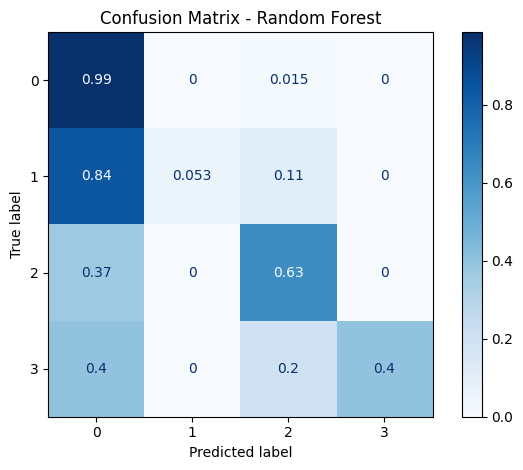

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    class_weight= 'balanced',
    random_state=42
)


rf.fit(X_train, y_train)

pred_y = rf.predict(X_test)

acc = accuracy_score(y_test, pred_y)
bacc = balanced_accuracy_score(y_test, pred_y)
print(f"Accuracy: {acc:.4f}  |  Balanced Acc.: {bacc:.4f}\n")

print("Reporte de clasificación:")
print(classification_report(y_test, pred_y, digits=4))

cm = confusion_matrix(y_test, pred_y, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

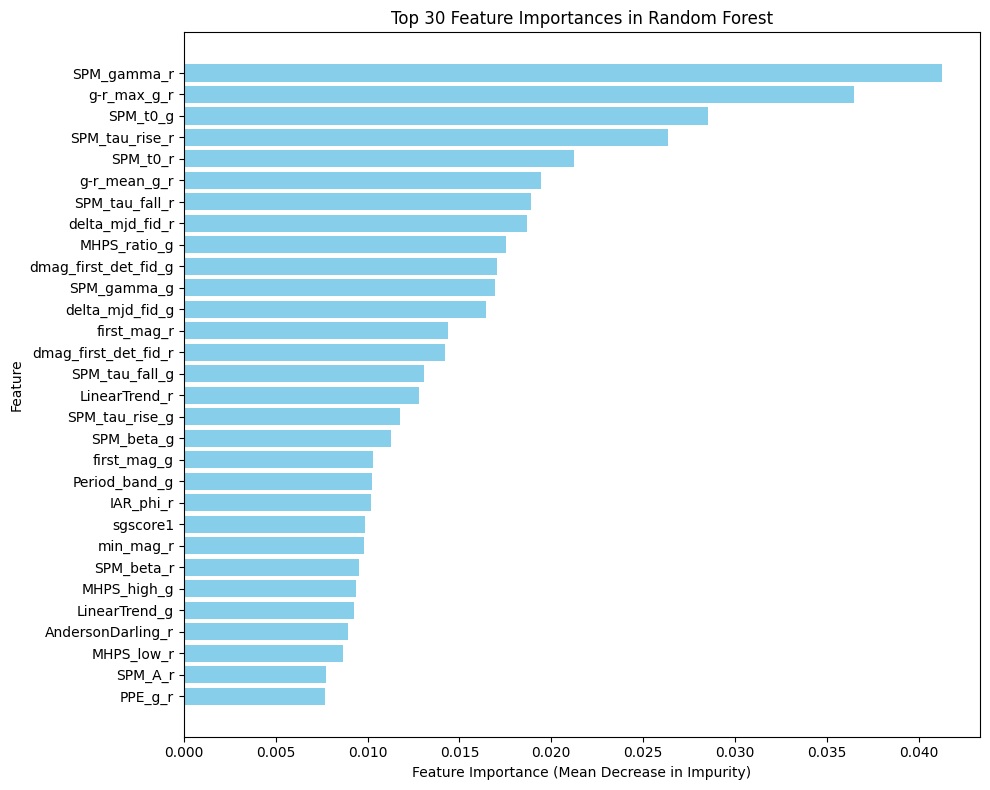

In [13]:
feature_names = lc_feat.drop(columns= ['oid','classALeRCE']).columns

# Importancias
importances = rf.feature_importances_

# Mapeo nombres a dataframe numérico para el plot
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
top_30_features = feature_importance_df.head(30)


plt.figure(figsize=(10, 8))
plt.barh(top_30_features['feature'], top_30_features['importance'], color='skyblue')
plt.xlabel("Feature Importance (Mean Decrease in Impurity)")
plt.ylabel("Feature")
plt.title("Top 30 Feature Importances in Random Forest")
plt.gca().invert_yaxis() # El más importante arriba
plt.tight_layout()
plt.show()


Embeddings: (365, 178), Labels: (365,)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


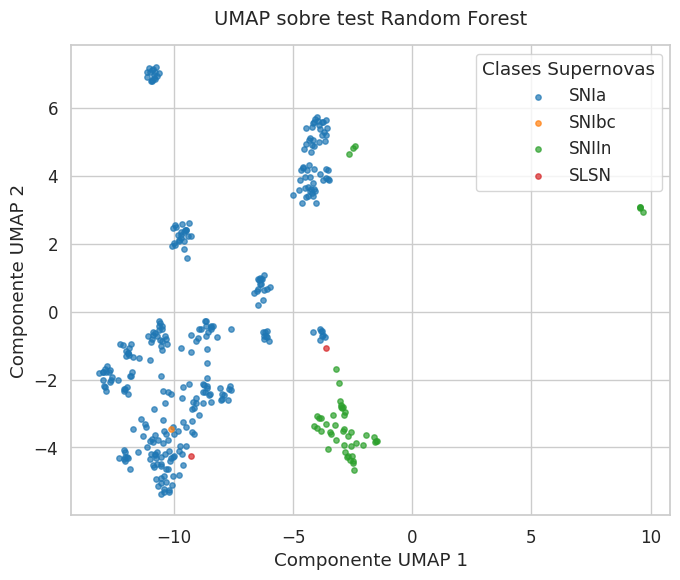

In [14]:
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

embeddings = X_test

test_y_np = rf.predict(X_test)

print(f"Embeddings: {embeddings.shape}, Labels: {test_y_np.shape}")

umap = UMAP(
    n_neighbors=30,
    min_dist=0.3,
    n_components=2,
    random_state=42,
    target_metric='categorical'
)
Z_umap = umap.fit_transform(embeddings, y=test_y_np)

plt.figure(figsize=(7,6))
sns.set(style="whitegrid", font_scale=1.1)

species_map = {'SNIa': 0, 'SNIbc': 1, 'SNII': 2, 'SLSN': 3, 'SNIIb': 2, 'SNIIn': 2}
species_inv = {v: k for k, v in species_map.items() if v in [0, 1, 2, 3]}
palette = {
    0: '#1f77b4',  # Azul - SNIa
    1: '#ff7f0e',  # Naranja - SNIbc
    2: '#2ca02c',  # Verde - SNII (incluye IIb, IIn)
    3: '#d62728',  # Rojo - SLSN
}

for class_id, name in species_inv.items():
    mask = (test_y_np == class_id)
    plt.scatter(
        Z_umap[mask, 0],
        Z_umap[mask, 1],
        s=15,
        alpha=0.7,
        color=palette[class_id],
        label=name
    )

plt.title("UMAP sobre test Random Forest", fontsize=14, pad=15)
plt.xlabel("Componente UMAP 1")
plt.ylabel("Componente UMAP 2")
plt.legend(title="Clases Supernovas", loc="best", frameon=True)
plt.tight_layout()
plt.show()


In [15]:
# RANDOM FOREST TIENE EL MEJOR DESEMPEÑO SIMILAR A DOCUMENTO ALeRCE

# Análisis con Balanced Random Forest

In [31]:
# A partir de acá MLP sacada casi todo de Aux 2
# Split the data
X = lc_feat.iloc[:, 1:-1].values
y = lc_feat['classALeRCE'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# En este caso sin balanceo previo para no modificar demasiado
# e introducir ruido

Accuracy: 0.7260  |  Balanced Acc.: 0.5971

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9095    0.7729    0.8356       273
           1     0.1129    0.3684    0.1728        19
           2     0.7333    0.6471    0.6875        68
           3     0.2727    0.6000    0.3750         5

    accuracy                         0.7260       365
   macro avg     0.5071    0.5971    0.5177       365
weighted avg     0.8265    0.7260    0.7672       365



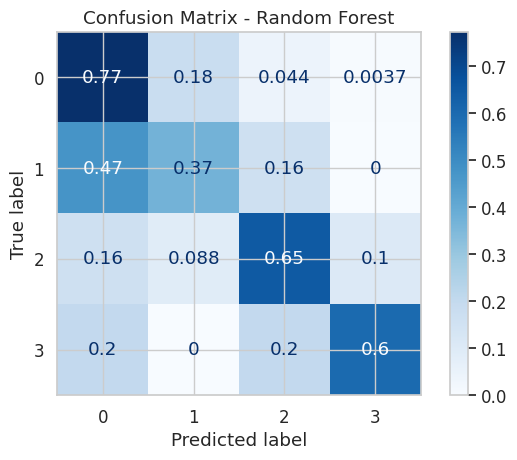

In [32]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(n_estimators=300,
    sampling_strategy="all", replacement=True, max_depth=None, random_state=0,
    bootstrap=False)

clf.fit(X_train, y_train)

pred_y = clf.predict(X_test)

acc = accuracy_score(y_test, pred_y)
bacc = balanced_accuracy_score(y_test, pred_y)
print(f"Accuracy: {acc:.4f}  |  Balanced Acc.: {bacc:.4f}\n")

print("Reporte de clasificación:")
print(classification_report(y_test, pred_y, digits=4))

cm = confusion_matrix(y_test, pred_y, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

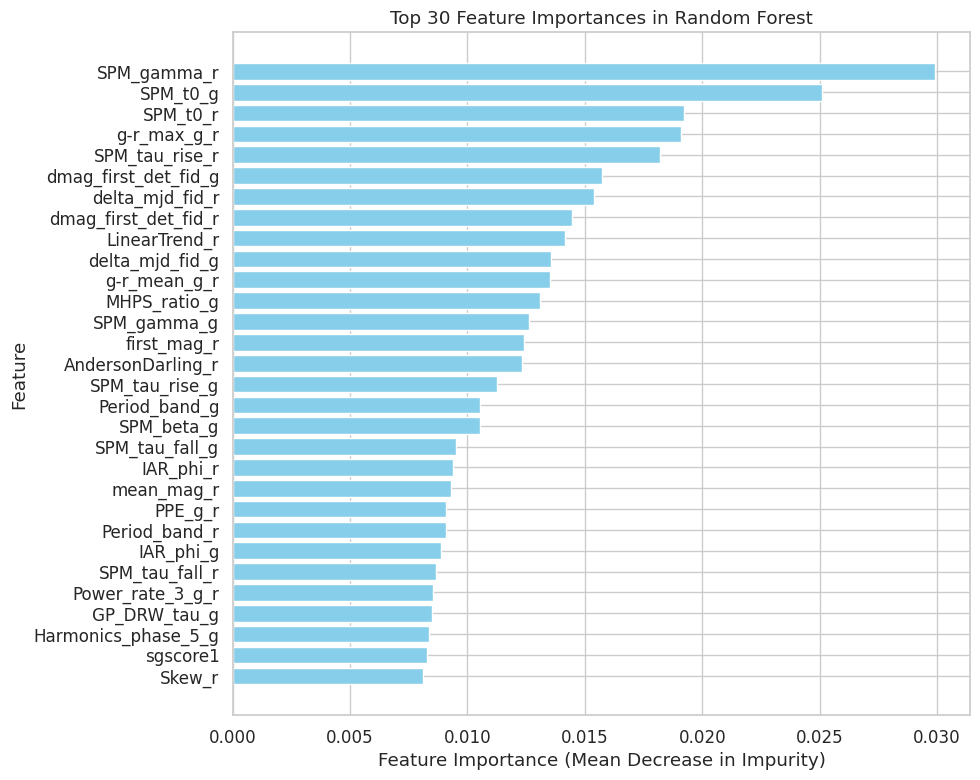

In [33]:
feature_names = lc_feat.drop(columns= ['oid','classALeRCE']).columns

# Importancias
importances = clf.feature_importances_

# Mapeo nombres a dataframe numérico para el plot
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
top_30_features = feature_importance_df.head(30)


plt.figure(figsize=(10, 8))
plt.barh(top_30_features['feature'], top_30_features['importance'], color='skyblue')
plt.xlabel("Feature Importance (Mean Decrease in Impurity)")
plt.ylabel("Feature")
plt.title("Top 30 Feature Importances in Random Forest")
plt.gca().invert_yaxis() # El más importante arriba
plt.tight_layout()
plt.show()


Embeddings: (365, 178), Labels: (365,)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


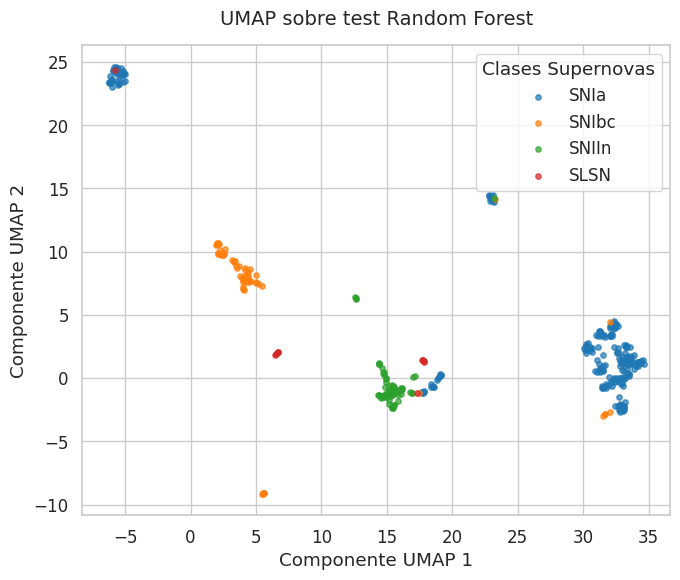

In [35]:
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

embeddings = X_test

test_y_np = clf.predict(X_test)

print(f"Embeddings: {embeddings.shape}, Labels: {test_y_np.shape}")

umap = UMAP(
    n_neighbors=30,
    min_dist=0.3,
    n_components=2,
    random_state=42,
    target_metric='categorical'
)
Z_umap = umap.fit_transform(embeddings, y=test_y_np)

plt.figure(figsize=(7,6))
sns.set(style="whitegrid", font_scale=1.1)

species_map = {'SNIa': 0, 'SNIbc': 1, 'SNII': 2, 'SLSN': 3, 'SNIIb': 2, 'SNIIn': 2}
species_inv = {v: k for k, v in species_map.items() if v in [0, 1, 2, 3]}
palette = {
    0: '#1f77b4',  # Azul - SNIa
    1: '#ff7f0e',  # Naranja - SNIbc
    2: '#2ca02c',  # Verde - SNII (incluye IIb, IIn)
    3: '#d62728',  # Rojo - SLSN
}

for class_id, name in species_inv.items():
    mask = (test_y_np == class_id)
    plt.scatter(
        Z_umap[mask, 0],
        Z_umap[mask, 1],
        s=15,
        alpha=0.7,
        color=palette[class_id],
        label=name
    )

plt.title("UMAP sobre test Balanced Random Forest", fontsize=14, pad=15)
plt.xlabel("Componente UMAP 1")
plt.ylabel("Componente UMAP 2")
plt.legend(title="Clases Supernovas", loc="best", frameon=True)
plt.tight_layout()
plt.show()


# Multiclass SVDD

In [18]:
!pip install umap-learn

In [19]:
# A partir de acá MLP sacada casi todo de Aux 2
# Split the data
X = lc_feat.iloc[:, 1:-1].values
y = lc_feat['classALeRCE'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Luego aplica balanceo solo en entrenamiento
undersample = RandomUnderSampler(sampling_strategy={0:800}, random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)

oversample = RandomOverSampler(sampling_strategy={1:500, 2:600, 3:500}, random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class MLPEncoder(nn.Module):
    def __init__(self, input_dim=178, hidden_dims=(256, 128),
                 embed_dim=32, num_classes=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_dims[1], embed_dim)
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        z = self.encoder(x)
        out = self.classifier(z)
        return out, z

In [21]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, lambda_c=1):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.lambda_c = lambda_c

    def forward(self, features, labels):
        centers_batch = self.centers[labels]
        loss = torch.mean((features - centers_batch) ** 2)
        return self.lambda_c * loss

In [22]:
def focal_loss(logits, targets, alpha=None, gamma=2.0):
    ce = F.cross_entropy(logits, targets, reduction='none', weight=alpha)
    pt = torch.exp(-ce)
    return ((1 - pt) ** gamma * ce).mean()

In [23]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPEncoder().to(device)

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion_cls = lambda logits, y: focal_loss(logits, y, alpha=weights, gamma=1.5)
criterion_center = CenterLoss(num_classes=4, feat_dim=32, lambda_c=0.1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

train_X_t = torch.FloatTensor(X_train).to(device)
train_y_t = torch.LongTensor(y_train).to(device)
test_X_t = torch.FloatTensor(X_test).to(device)
test_y_t = torch.LongTensor(y_test).to(device)

best_f1 = 0
for epoch in range(700):
    model.train()
    optimizer.zero_grad()
    out, z = model(train_X_t)
    loss_cls = criterion_cls(out, train_y_t)
    loss_center = criterion_center(z, train_y_t)
    loss = loss_cls + loss_center
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            preds, z_val = model(test_X_t)
            y_pred = preds.argmax(1)
            f1 = f1_score(test_y_t.cpu(), y_pred.cpu(), average='macro')
        print(f"Epoch {epoch} | Loss={loss.item():.3f} | Macro-F1={f1:.3f} | Center={loss_center.item():.3f}")
        if f1 > best_f1:
            best_f1 = f1

Epoch 0 | Loss=1.037 | Macro-F1=0.072 | Center=0.107
Epoch 100 | Loss=0.706 | Macro-F1=0.093 | Center=0.074
Epoch 200 | Loss=0.566 | Macro-F1=0.161 | Center=0.070
Epoch 300 | Loss=0.483 | Macro-F1=0.255 | Center=0.066
Epoch 400 | Loss=0.434 | Macro-F1=0.248 | Center=0.063
Epoch 500 | Loss=0.387 | Macro-F1=0.272 | Center=0.059
Epoch 600 | Loss=0.348 | Macro-F1=0.258 | Center=0.057


Embeddings: (365, 32), Labels: (365,)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


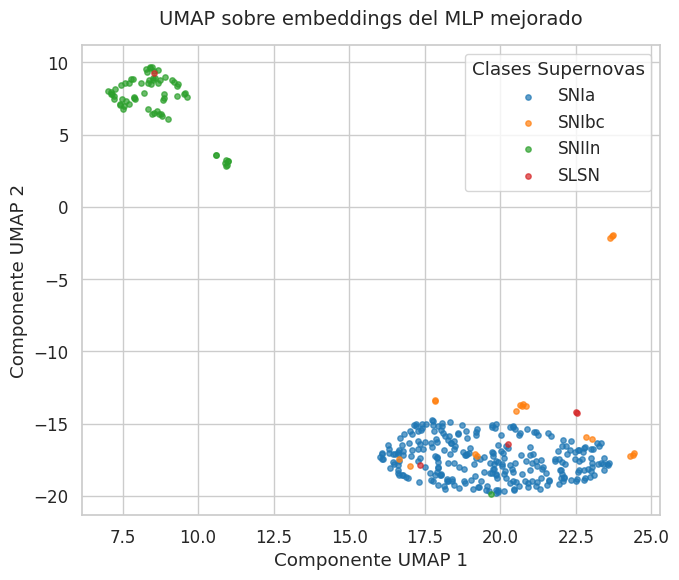

In [24]:
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns


with torch.no_grad():
    model.eval()
    _, embeddings = model(test_X_t)
    embeddings = embeddings.cpu().numpy()

test_y_np = test_y_t.cpu().numpy()

print(f"Embeddings: {embeddings.shape}, Labels: {test_y_np.shape}")

umap = UMAP(
    n_neighbors=30,
    min_dist=0.3,
    n_components=2,
    random_state=42,
    target_metric='categorical'
)
Z_umap = umap.fit_transform(embeddings, y=test_y_np)

plt.figure(figsize=(7,6))
sns.set(style="whitegrid", font_scale=1.1)

species_map = {'SNIa': 0, 'SNIbc': 1, 'SNII': 2, 'SLSN': 3, 'SNIIb': 2, 'SNIIn': 2}
species_inv = {v: k for k, v in species_map.items() if v in [0, 1, 2, 3]}
palette = {
    0: '#1f77b4',  # Azul - SNIa
    1: '#ff7f0e',  # Naranja - SNIbc
    2: '#2ca02c',  # Verde - SNII (incluye IIb, IIn)
    3: '#d62728',  # Rojo - SLSN
}

for class_id, name in species_inv.items():
    mask = (test_y_np == class_id)
    plt.scatter(
        Z_umap[mask, 0],
        Z_umap[mask, 1],
        s=15,
        alpha=0.7,
        color=palette[class_id],
        label=name
    )

plt.title("UMAP sobre embeddings del MLP mejorado", fontsize=14, pad=15)
plt.xlabel("Componente UMAP 1")
plt.ylabel("Componente UMAP 2")
plt.legend(title="Clases Supernovas", loc="best", frameon=True)
plt.tight_layout()
plt.show()


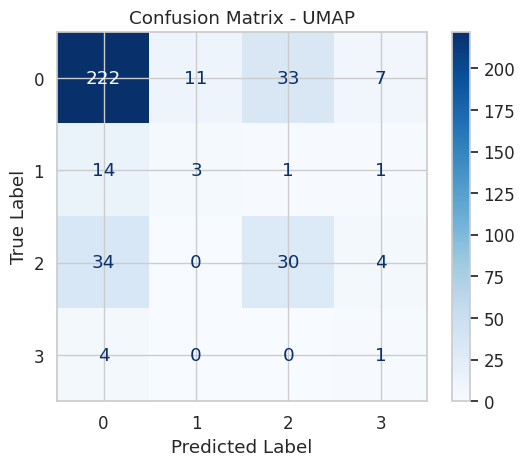

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Evaluación del modelo
net.eval()  # Poner la red en modo de evaluación (desactiva dropout, batchnorm, etc.)
with torch.no_grad():  # No calcular los gradientes para la evaluación (reduce el uso de memoria y tiempo de cálculo)
    predict_out = net(test_X_t.to(device))  # Hacer una pasada hacia adelante con los datos de prueba
    _, predict_y = torch.max(predict_out, 1)  # Obtener las clases predichas usando la salida con mayor probabilidad
# Assuming test_y and predict_y are your true and predicted labels
test_y = torch.LongTensor(y_test)
cm = confusion_matrix(test_y_t.detach().cpu().numpy(), predict_y.detach().cpu().numpy())

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix - UMAP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


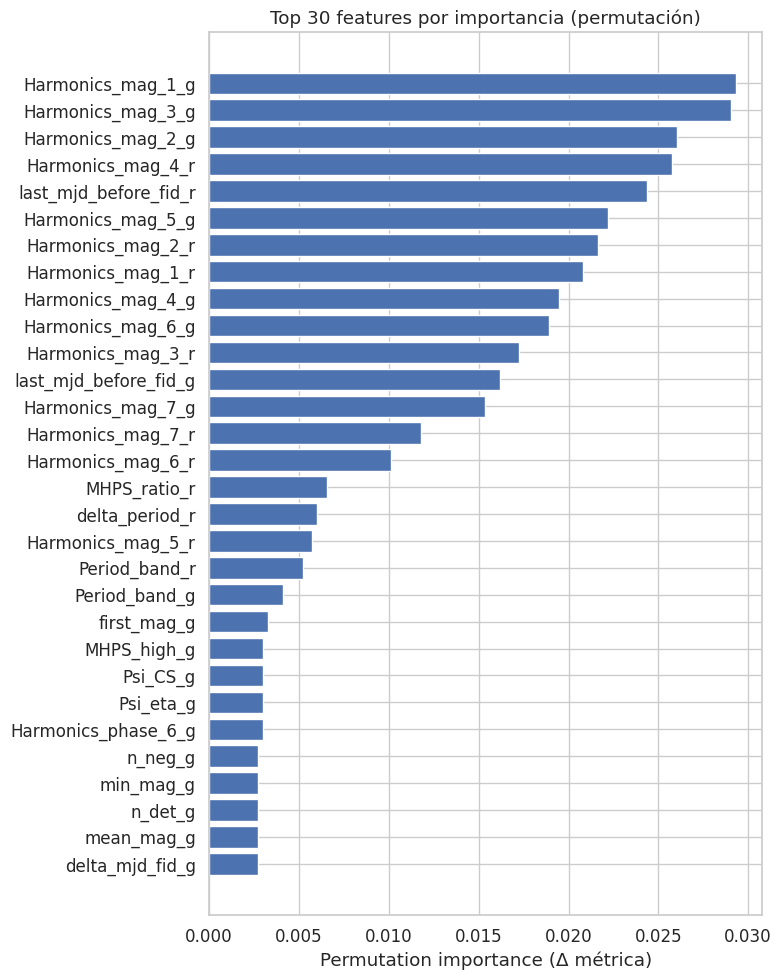

                  feature  importance  abs_importance
0       Harmonics_mag_1_g    0.029315        0.029315
1       Harmonics_mag_3_g    0.029041        0.029041
2       Harmonics_mag_2_g    0.026027        0.026027
3       Harmonics_mag_4_r    0.025753        0.025753
4   last_mjd_before_fid_r    0.024384        0.024384
5       Harmonics_mag_5_g    0.022192        0.022192
6       Harmonics_mag_2_r    0.021644        0.021644
7       Harmonics_mag_1_r    0.020822        0.020822
8       Harmonics_mag_4_g    0.019452        0.019452
9       Harmonics_mag_6_g    0.018904        0.018904
10      Harmonics_mag_3_r    0.017260        0.017260
11  last_mjd_before_fid_g    0.016164        0.016164
12      Harmonics_mag_7_g    0.015342        0.015342
13      Harmonics_mag_7_r    0.011781        0.011781
14      Harmonics_mag_6_r    0.010137        0.010137
15           MHPS_ratio_r    0.006575        0.006575
16         delta_period_r    0.006027        0.006027
17      Harmonics_mag_5_r   

In [26]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

def calculate_permutation_importance(
    model, X_test, y_test, metric_fn=accuracy_score,
    feature_names=None, n_repeats=10, seed=42, device=None
):
    """
    Acepta X_test / y_test como numpy o torch.Tensor.
    Devuelve un DataFrame con 'feature', 'importance', 'abs_importance' (ordenado desc).
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device


    if isinstance(X_test, np.ndarray):
        X_test_t = torch.from_numpy(X_test).float().to(device)
    elif isinstance(X_test, torch.Tensor):
        X_test_t = X_test.to(device).float()
    else:
        raise TypeError("X_test debe ser numpy.ndarray o torch.Tensor")

    if isinstance(y_test, np.ndarray):
        y_test_t = torch.from_numpy(y_test).long().to(device)
    elif isinstance(y_test, torch.Tensor):
        y_test_t = y_test.to(device).long()
    else:
        raise TypeError("y_test debe ser numpy.ndarray o torch.Tensor")


    with torch.no_grad():
        logits = model(X_test_t)
        y_pred = logits.argmax(1).cpu().numpy()
    y_true = y_test_t.detach().cpu().numpy()
    baseline = metric_fn(y_true, y_pred)

    N, D = X_test_t.shape
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(D)]

    rng = torch.Generator(device=device)
    rng.manual_seed(seed)

    importances = np.zeros(D, dtype=np.float32)

    with torch.no_grad():
        for j in range(D):
            drops = []
            for _ in range(n_repeats):
                Xp = X_test_t.clone()
                idx = torch.randperm(N, generator=rng, device=device)
                Xp[:, j] = Xp[idx, j]
                yp = model(Xp).argmax(1).cpu().numpy()
                score_p = metric_fn(y_true, yp)
                drops.append(baseline - score_p)
            importances[j] = float(np.mean(drops))

    df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances,
        "abs_importance": np.abs(importances)
    }).sort_values("importance", ascending=False).reset_index(drop=True)
    return df


device = next(net.parameters()).device
feature_names = lc_feat.columns[1:-1].tolist()
imp_df = calculate_permutation_importance(
    net, test_X_t, test_y_t,
    metric_fn=accuracy_score,
    feature_names=feature_names,
    n_repeats=10, seed=42, device=device
)


top_k = 30
top_df = imp_df.head(top_k).copy()
top_df_sorted_for_plot = top_df.sort_values("importance", ascending=True)

plt.figure(figsize=(8, 10))
plt.barh(top_df_sorted_for_plot["feature"], top_df_sorted_for_plot["importance"])
plt.xlabel("Permutation importance (Δ métrica)")
plt.title(f"Top {top_k} features por importancia (permutación)")
plt.tight_layout()
plt.show()

print(top_df)


# Outliers

In [27]:
# Faltan cosillas outliers